#**Business Objective:**

The goal of this project is to develop a robust forecasting model for hourly energy consumption within the PJM Interconnection region of the United States. Using historical megawatt (MW) demand data, the project aims to uncover patterns related to hourly usage, seasonality, and holiday effects, and to ultimately generate accurate 30-day energy demand forecasts. These insights can support operational planning, peak load management, and data-driven energy distribution across PJM's extensive multi-state grid.

#Dataset Details:

* **Datetime:** This column has the date and time recorded for the energy demand.
* **PJMW_MW:** This column has the enery units recorded at the given particular date and time.

In [56]:
#  Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [57]:
#  Load the dataset
df = pd.read_csv("/content/PJMW_Energy_Demand.csv")
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [58]:
df.shape

(143206, 2)

In [59]:
df.columns

Index(['Datetime', 'PJMW_MW'], dtype='object')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [61]:
# Checking for Null Values
print(df.isnull().sum().sum())

0


In [62]:
# Let's Check for duplicates
print(df.duplicated().sum())

0


In [63]:
# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [64]:
# Set 'Datetime' as the index for time-series analysis
df.set_index('Datetime', inplace=True)

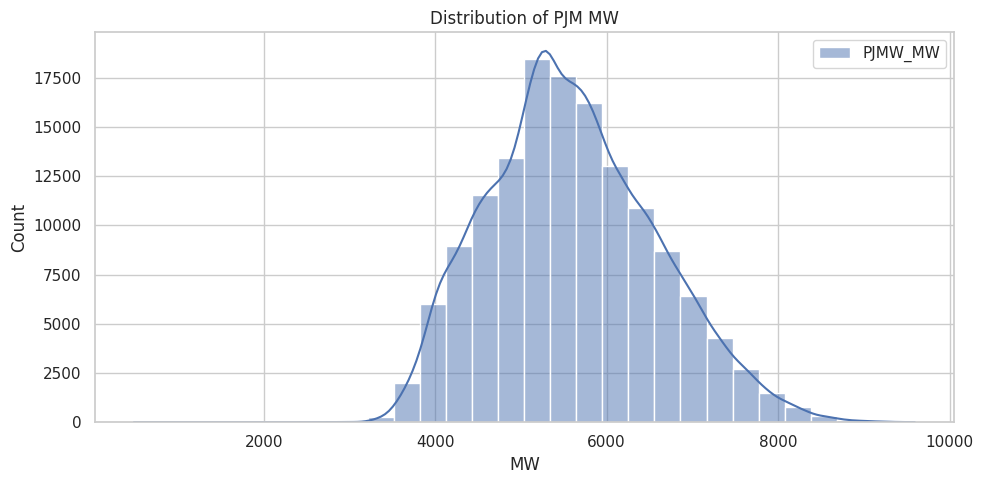

In [66]:
# Distribution of of PJMW_MW column
plt.figure(figsize=(10, 5))
sns.histplot(df, kde=True, bins=30, color='tab:green')
plt.title('Distribution of PJM MW')
plt.xlabel('MW')
plt.tight_layout()
plt.show()

In [68]:
#  Feature Engineering: Add useful time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # Monday = 0, Sunday = 6
df['weekday_name'] = df.index.day_name()
df['month'] = df.index.month
df['year'] = df.index.year
df['day'] = df.index.day
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['Season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall',   10: 'Fall',  11: 'Fall'
})

#  Add US federal holidays
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df.index.min(), end=df.index.max())
df['is_holiday'] = df.index.isin(holidays).astype(int)

In [69]:
df.head()

,PJMW_MW,hour,dayofweek,weekday_name,month,year,day,is_weekend,Season,is_holiday
Datetime,,,,,,,,,,
2002-12-31 01:00:00,5077.0,1,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 02:00:00,4939.0,2,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 03:00:00,4885.0,3,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 04:00:00,4857.0,4,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 05:00:00,4930.0,5,1,Tuesday,12,2002,31,0,Winter,0


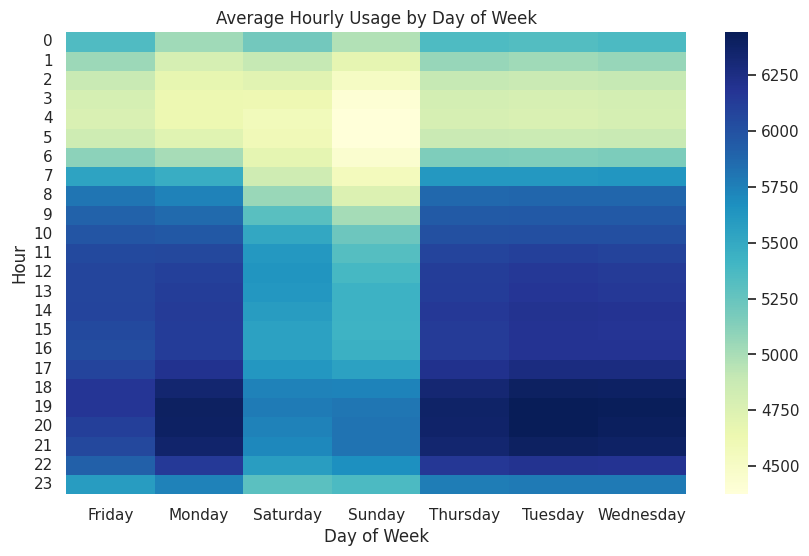

In [70]:
# Heatmap: Average Hourly Usage by Day of Week
# Shows patterns in usage across different hours and weekdays
pivot1 = df.pivot_table(values='PJMW_MW', index='hour', columns='weekday_name', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot1, cmap="YlGnBu")
plt.title("Average Hourly Usage by Day of Week")
plt.ylabel("Hour")
plt.xlabel("Day of Week")
plt.show()

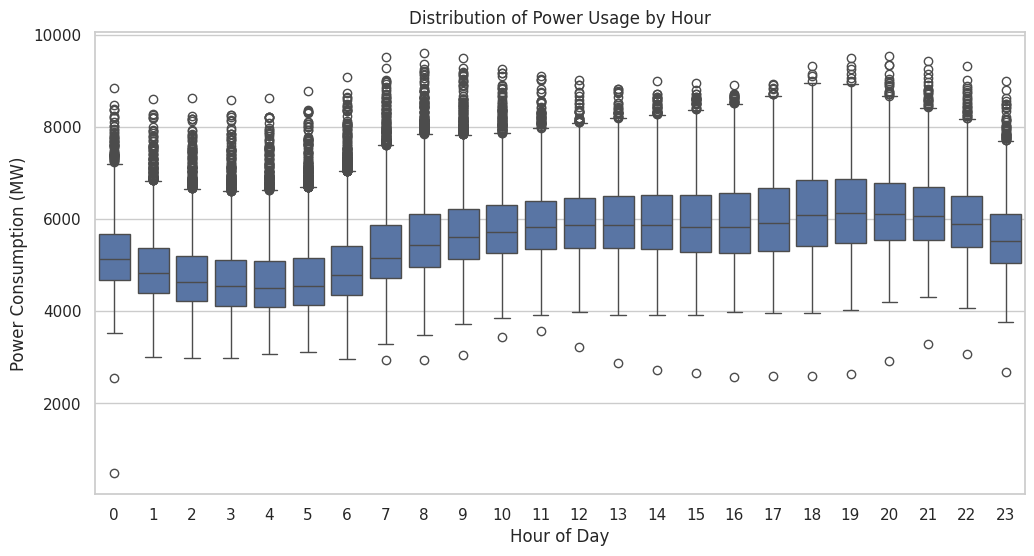

In [71]:
# Boxplot: Hourly Distribution
# Helps understand variation and outliers in energy use per hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='PJMW_MW', data=df)
plt.title("Distribution of Power Usage by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Power Consumption (MW)")
plt.show()

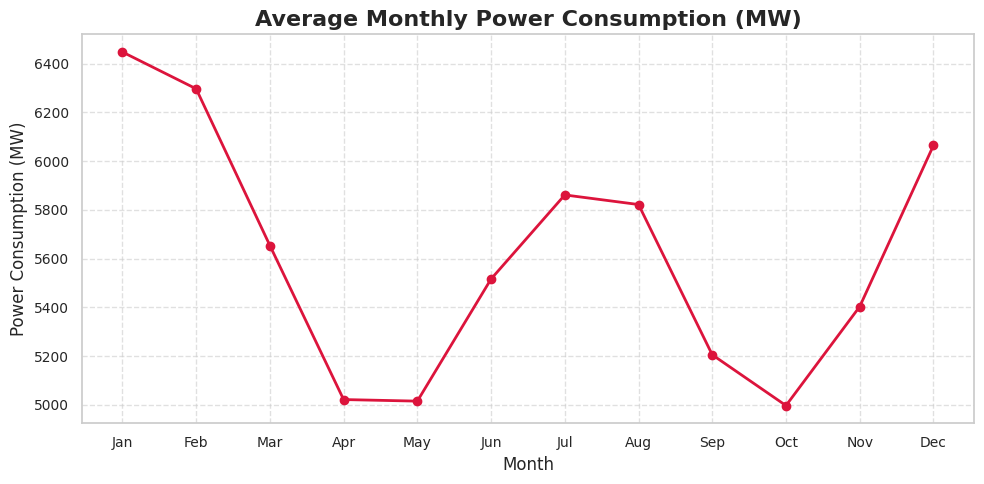

In [72]:
monthly_avg = df.groupby('month')['PJMW_MW'].mean()

# Month names for x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(month_names, monthly_avg.values, marker='o', color='crimson', linewidth=2)

# Beautify
plt.title("Average Monthly Power Consumption (MW)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Power Consumption (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show
plt.show()

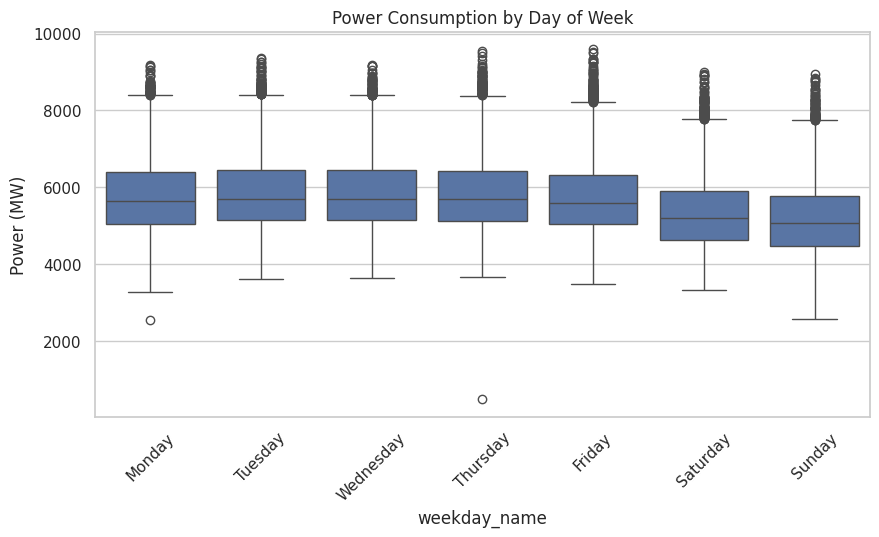

In [73]:
# Boxplot: Day of Week
# Examines energy usage spread for each day of the week
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday_name', y='PJMW_MW', data=df,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Power Consumption by Day of Week")
plt.xticks(rotation=45)
plt.ylabel("Power (MW)")
plt.show()

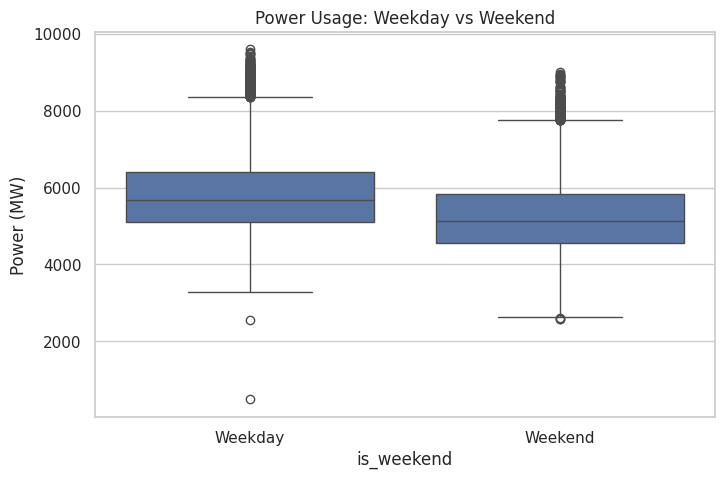

In [74]:
# Boxplot: Weekend vs Weekday
# Checks if weekends show different energy use compared to weekdays
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_weekend', y='PJMW_MW', data=df)
plt.title("Power Usage: Weekday vs Weekend")
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.ylabel("Power (MW)")
plt.show()

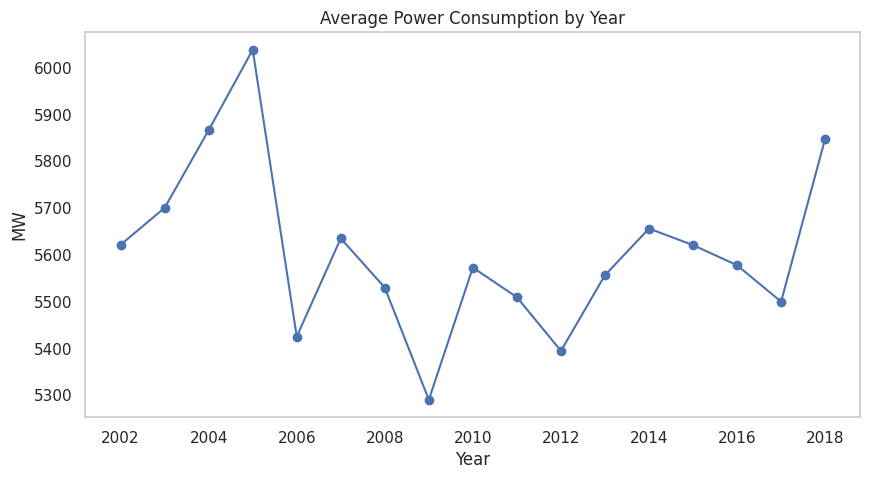

In [75]:
# Lineplot: Average Usage by Year
# Shows long-term trend over the years
yearly_avg = df.groupby('year')['PJMW_MW'].mean()
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title("Average Power Consumption by Year")
plt.xlabel("Year")
plt.ylabel("MW")
plt.grid()
plt.show()

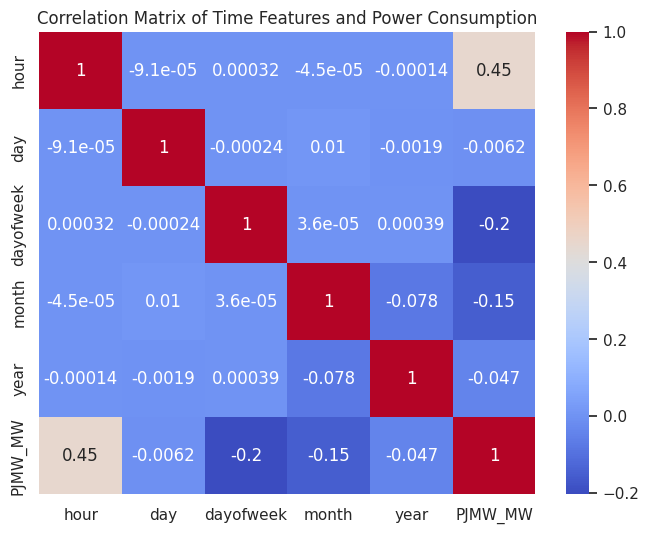

In [76]:
# Correlation Heatmap
# Displays relationships between time-based features and power usage
plt.figure(figsize=(8, 6))
correlation = df[['hour', 'day', 'dayofweek', 'month', 'year', 'PJMW_MW']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Time Features and Power Consumption")
plt.show()

In [77]:
# Resampling the data on daily baisis and taking each day's mean value
df = round(df["PJMW_MW"].resample('D').mean(),2)
df = df.sort_index()
df

,PJMW_MW
Datetime,
2002-04-01,5271.17
2002-04-02,5310.42
2002-04-03,5325.92
2002-04-04,5670.79
2002-04-05,5686.12
...,...
2018-07-30,5492.71
2018-07-31,5660.75
2018-08-01,5959.71
